# Bayesian inference in non-linear dynamic models

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.integrate import solve_ivp
import scipy.optimize

import warnings
warnings.simplefilter('ignore', FutureWarning)
from numba import NumbaDeprecationWarning
warnings.simplefilter('ignore', NumbaDeprecationWarning)

red, blue, green = sns.color_palette('Set1', 3)

The analysis follows an example from the [PyMC docs](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#pymc-model-specification-for-gradient-free-bayesian-inference).

# Predator-prey data

Here's data from a real predator-prey system -- the hare and lynx system, see for example:
> Krebs, Boonstra, Boutin, Sinclair (2006). [What drives the 10-year cycle of snowshoe hares?](https://www.bio.fsu.edu/~james/krebs.pdf) _BioScience_

> Deng (2018). [An Inverse Problem: Trappers Drove Hares to Eat Lynx.](https://doi.org/10.1007/s10441-018-9333-z) _Acta Biotheoretica_

In [5]:
t = np.arange(1900., 1921., 1)
lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
            8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
             27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
xy = np.array([hare, lynx])

The first column is years, the second is hare population size, the third is lynx population size.

Let's plot the data.

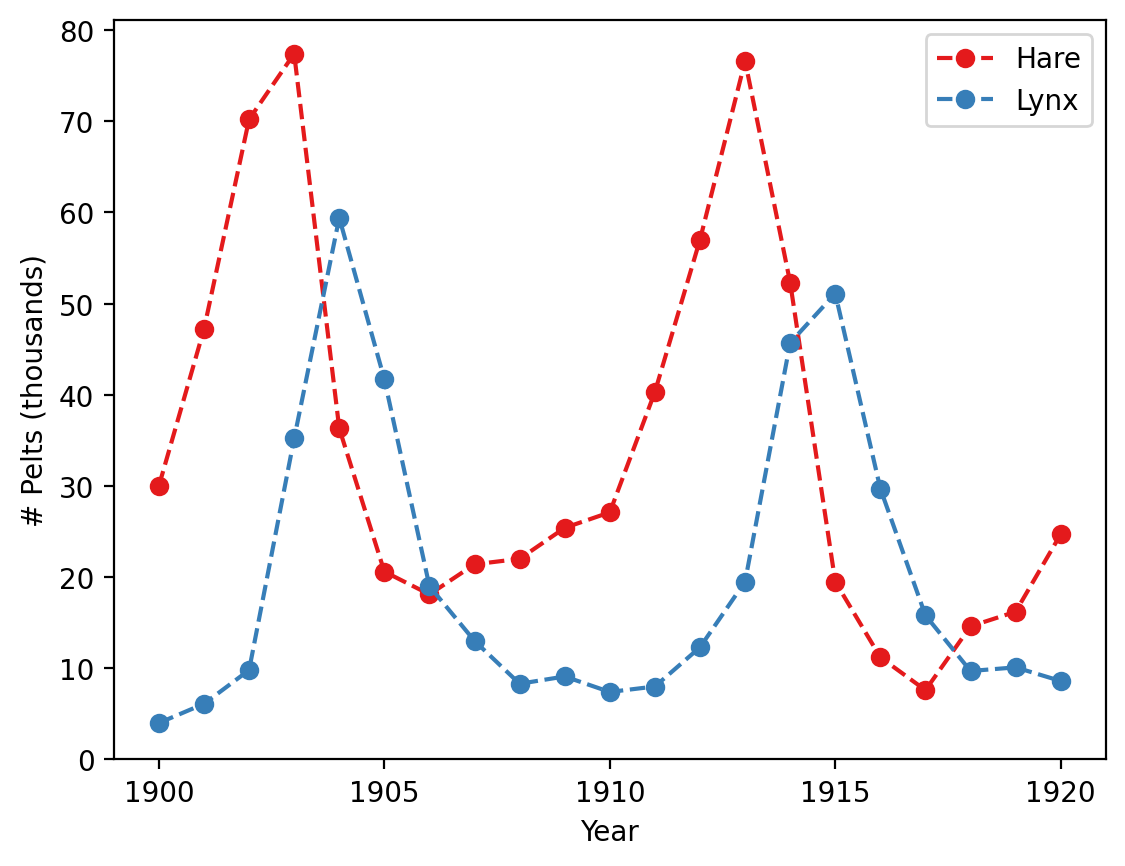

In [6]:
def plot_setup():
    plt.plot(t, hare, 'o--', color=red)
    plt.plot(t, lynx, 'o--', color=blue)
    plt.xlabel('Year')
    plt.ylabel('# Pelts (thousands)')
    plt.legend(['Hare', 'Lynx'])
    plt.ylim(0, None)
    plt.xticks([1900, 1905, 1910, 1915, 1920])

plot_setup()

We can see the cycles that we discussed in the predator-prey class.

# Predator-prey model

This is the same model we used earlier in the course.
I use [Numba]() JIT-compile the functions to improve running time, as we will run these functions many many times.

In [7]:
from numba import njit

@njit
def ode(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return [dx, dy]

# some ODE solvers need this, but we don't use them here
# @njit
# def jac(t, xy, b, h, ϵ, d):
#     x, y = xy
#     return [
#         [b - h * y, -h * x],
#         [ϵ * h * y, ϵ * h * x - d]
#     ]

def predator_prey_model(θ, t=t):
    θ = np.maximum(θ, 0) # parameters cannot be negative
    sol = solve_ivp(ode, (t.min(), t.max()), θ[-2:], t_eval=t, args=θ[:-2])
    # assert sol.success, θ
    return np.array([sol.y[0], sol.y[1]])

Let's plot some guess for the model parameters and the data. I played a bit with the parameters to get something that looks close enough. You can play with them further.

CPU times: user 3.64 ms, sys: 22 µs, total: 3.66 ms
Wall time: 3.69 ms


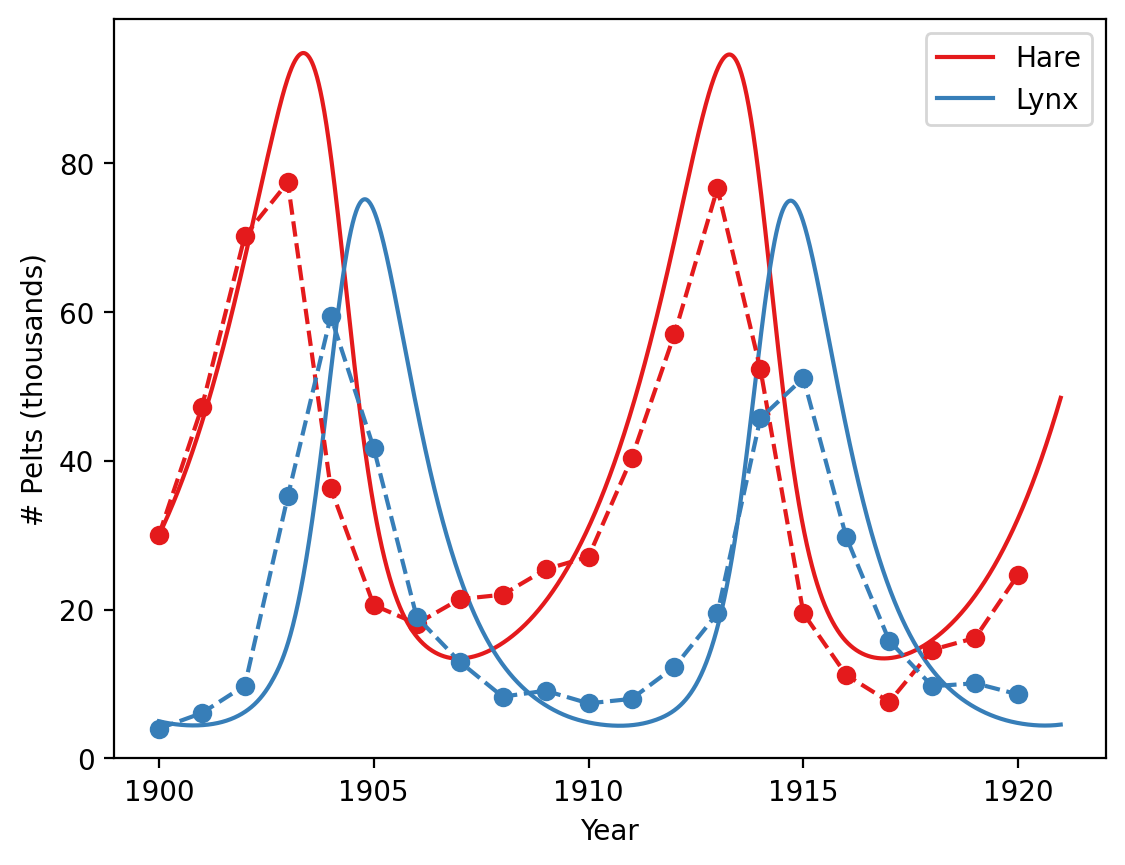

In [8]:
θ_guess = np.array([0.5, 0.02, 1.2, 1.0, 30.0, 5.0])
trange = np.arange(1900, 1921, 0.01)
predator_prey_model(θ_guess, trange) # burn in for jit
%time xhat, yhat = predator_prey_model(θ_guess, trange)
plt.plot(trange, xhat, color=red)
plt.plot(trange, yhat, color=blue)
plot_setup()

# Maximum likelihood estimation

We first assume that observed values are normally distributed around the expected values, which are given by the solution of the ODE. 

Maximizing the log likelihood of the normal distribution reduces down to minimizing the sum of residual squares, so we define a loss function that computes the predicted $x$ and $y$ and then computes the residual mean squares. 
Since we don't have gradeints of the loss with respect to the model paramters $\theta$, we use a minimization algorithm that does not require gradients: the [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder–Mead_method).

In [9]:
import scipy.optimize

def loss(θ, t, xy):
    xyhat = predator_prey_model(θ, t)
    return np.mean((xyhat - xy)**2)

%time sol = scipy.optimize.minimize(loss, θ_guess, args=(t, xy), method='Nelder-Mead')
θ_mle = sol.x
print(sol.message)
print('loss={:.4f}\nb = {:.4f}\nh = {:.4f}\nϵ = {:.4f}\nd = {:.4f}\nx0 = {:.2f}\ny0 = {:.4f}'.format(sol.fun, *θ_mle))

CPU times: user 1.79 s, sys: 17.6 ms, total: 1.81 s
Wall time: 1.83 s
Optimization terminated successfully.
loss=14.7500
b = 0.4978
h = 0.0249
ϵ = 1.0329
d = 0.8711
x0 = 35.67
y0 = 4.6651


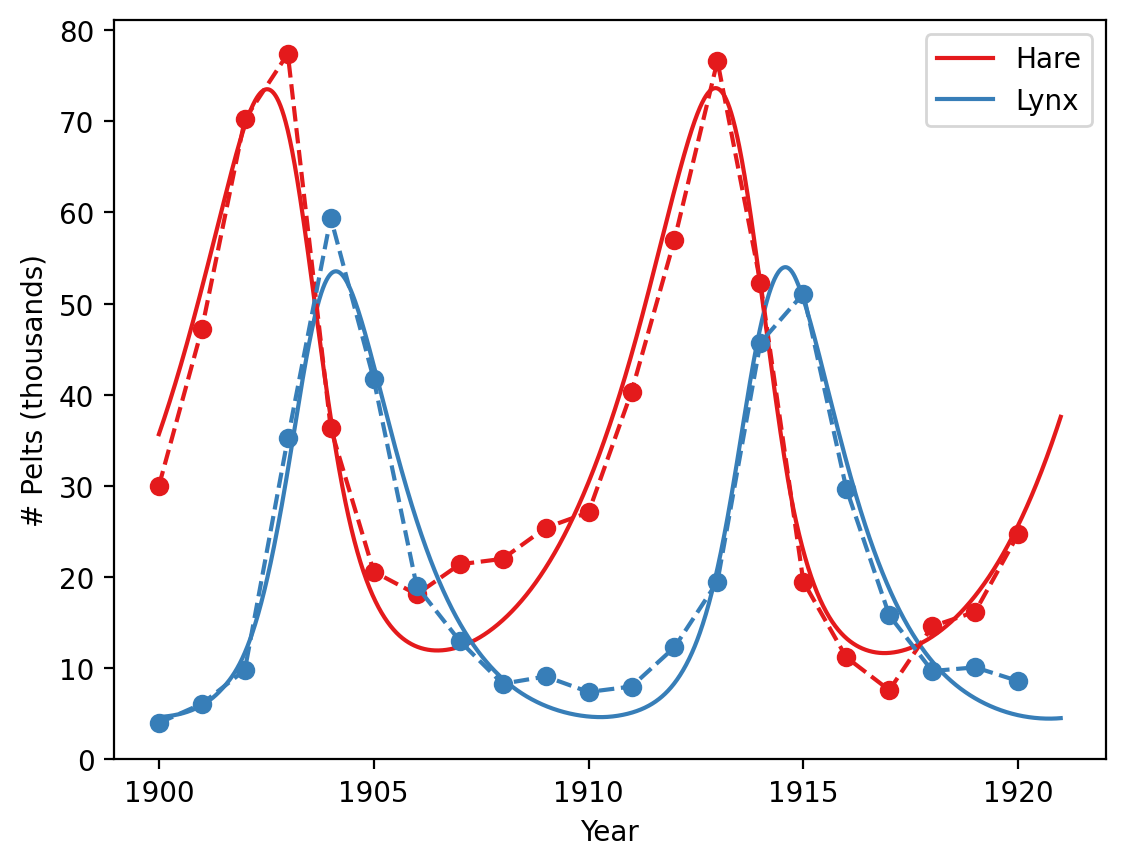

In [10]:
xhat, yhat = predator_prey_model(θ_mle, trange)
plt.plot(trange, xhat, color=red)
plt.plot(trange, yhat, color=blue)
plot_setup();

This looks pretty good.

In the following we test the sensitivity of this approach to the guess - it is not sensitive, so that's good!

In [97]:
θ_guesses = np.random.uniform(0, 40, size=(10, 6))
assert (θ_guesses > 0).all()
for θ_ in θ_guesses:
    sol = scipy.optimize.minimize(loss, θ_guess, args=(t, xy), method='Nelder-Mead')
    if not sol.success:
        print(sol.message)
    θ_mle_ = sol.x
    print('loss={:.2f}, b={:.2f}, h={:.2f}, ϵ={:.2f}, d={:.2f}, x0={:.2f}, y0={:.2f}'.format(sol.fun, *θ_mle_))

loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67
loss=14.75, b=0.50, h=0.02, ϵ=1.03, d=0.87, x0=35.67, y0=4.67


Another method that does use the gradients is illustrated at the bottom of the notebook. It uses a more sophisticated approach based on an ODE solver that can compute gradients of the solution with respect to the parameters, and an efficient gradient-descent solver called ADAM.

# Bayesian inference

Next, we apply Bayesian inference to the problem using [PyMC](https://pymc.io).

In [11]:
import pymc as pm
import arviz as az

print('PyMC', pm.__version__, 'Arviz', az.__version__)

PyMC 5.5.0 Arviz 0.15.1


We need to wrap our ODE model function `predator_prey_model` to a [pytensor](http://pytensor.readthedocs.io) function, because pytensor is the computational backend of PyMC (since v5). This is easily done by the following cell, which just defines the input and output types of the model function: `dvector` and `dmatrix` are a vector and a matrix of doubles, respectively.

In [12]:
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def predator_prey_model_op(θ):
    return predator_prey_model(θ)

The priors are defined as truncated normal distributions around the MLE; the truncation at zero avoids negative values for the parameters.

We set the distribution of the observations as Poisson around the expected value, as this is more reasonable than assuming a normal distribution.

We then sample from the posterior. I used the `Slice` sampler, which does not require gradients of the log-likelihood with respect to the model parameters (we could [do it with gradients](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_with_manual_gradients.html), but it will complicate the source code). Each chain took me about 15 mins to run on my laptop. You can [try another sampler if you want](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#pymc-model-specification-for-gradient-free-bayesian-inference).

In [14]:
with pm.Model() as model:   
    b_mle, h_mle, ϵ_mle, d_mle, x0_mle, y0_mle = θ_mle
    b = pm.TruncatedNormal("b", mu=b_mle, sigma=0.1, lower=0, initval=b_mle)
    h = pm.TruncatedNormal("h", mu=h_mle, sigma=0.01, lower=0, initval=h_mle)
    ϵ = pm.TruncatedNormal("ϵ", mu=ϵ_mle, sigma=0.1, lower=0, initval=ϵ_mle)
    d = pm.TruncatedNormal("d", mu=d_mle, sigma=0.01, lower=0, initval=d_mle)
    x0 = pm.TruncatedNormal("x0", mu=x0_mle, sigma=1, lower=0, initval=x0_mle)
    y0 = pm.TruncatedNormal("y0", mu=y0_mle, sigma=1, lower=0, initval=y0_mle)

    ode_solution = predator_prey_model_op(pm.math.stack([b, h, ϵ, d, x0, y0]))
    XY_obs = pm.Poisson("XY_obs", mu=ode_solution, observed=xy)

In [ ]:
with model:
    idata = pm.sample(step=[pm.Slice()], draws=2000, cores=1)
az.summary(idata)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [b]
>Slice: [h]
>Slice: [ϵ]
>Slice: [d]
>Slice: [x0]
>Slice: [y0]


The following saves and then loads the inference data to and from a file, so that we can continue working on it at a later time.

In [ ]:
idata.to_netcdf("idata_hare_lynx.nc")

In [3]:
idata = az.from_netcdf("idata_hare_lynx.nc")

Next we plot the traces and the marginal posteriors of the two chains to assess for convergence.

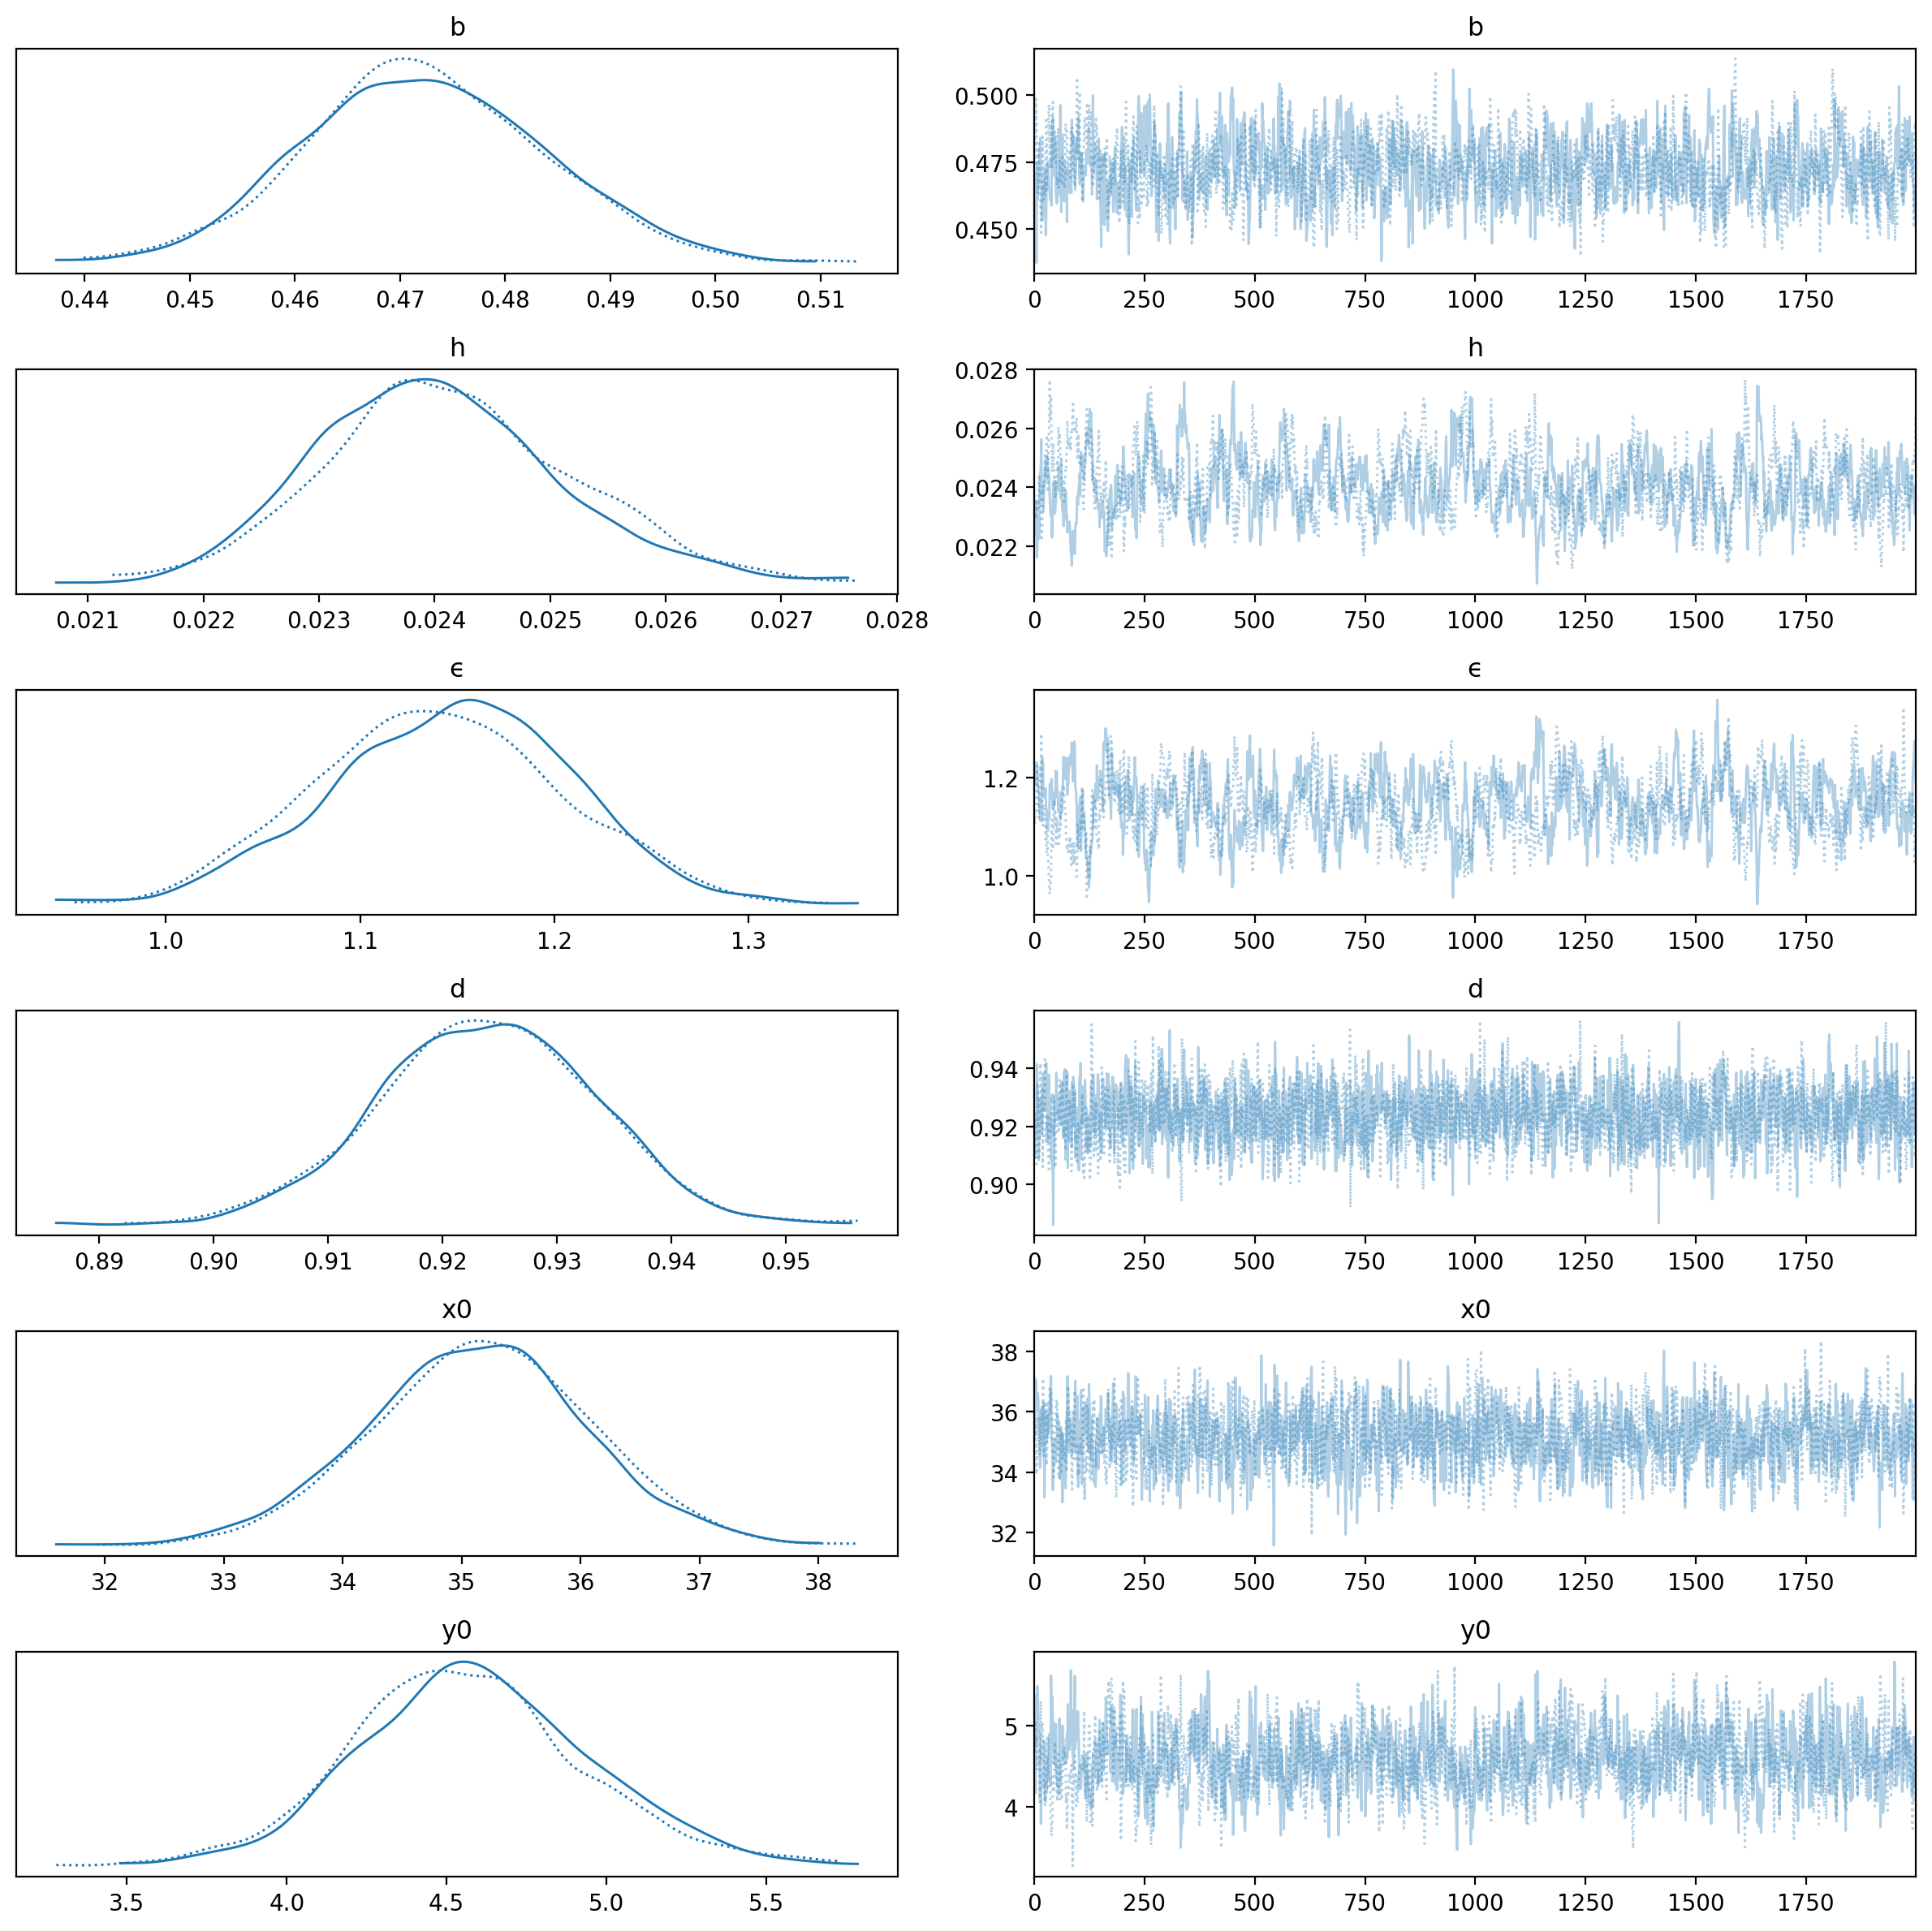

In [39]:
az.plot_trace(idata)
plt.tight_layout()

It seems that the chains have converged, so we can go ahead and look at the summary of the inference.

Not the `r_hat` and `ess` are measures for convergence and stability, respectively, read more at [Kruschke (2021) Bayesian Analysis Reporting Guidelines. _Nature Human Behaviour_](https://doi.org/10.1038/s41562-021-01177-7).

In [16]:
isummary = az.summary(idata, round_to=4)
isummary

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
b    0.4724  0.0113   0.4518   0.4941     0.0004   0.0003   667.0881   
h    0.0241  0.0011   0.0221   0.0261     0.0001   0.0000   266.1109   
ϵ    1.1437  0.0615   1.0283   1.2547     0.0037   0.0026   271.6627   
d    0.9238  0.0094   0.9052   0.9403     0.0002   0.0002  1617.5820   
x0  35.1449  0.9125  33.4343  36.8711     0.0233   0.0164  1539.1009   
y0   4.5769  0.3610   3.9058   5.2790     0.0142   0.0101   635.6277   

     ess_tail   r_hat  
b   1137.9276  1.0020  
h    546.2875  1.0135  
ϵ    753.1725  1.0132  
d   2706.1872  1.0002  
x0  2421.5999  1.0015  
y0  1540.7117  1.0041

Next, let's plot predictive plots to check if the estimated parameters can indeed reproduce the dynamics we observe in the data.

Here, I plot the data as circles, the dynamics using the MAP estimate as black lines, and the dynamics using 100 samples from the posterior as colored transparent lines.

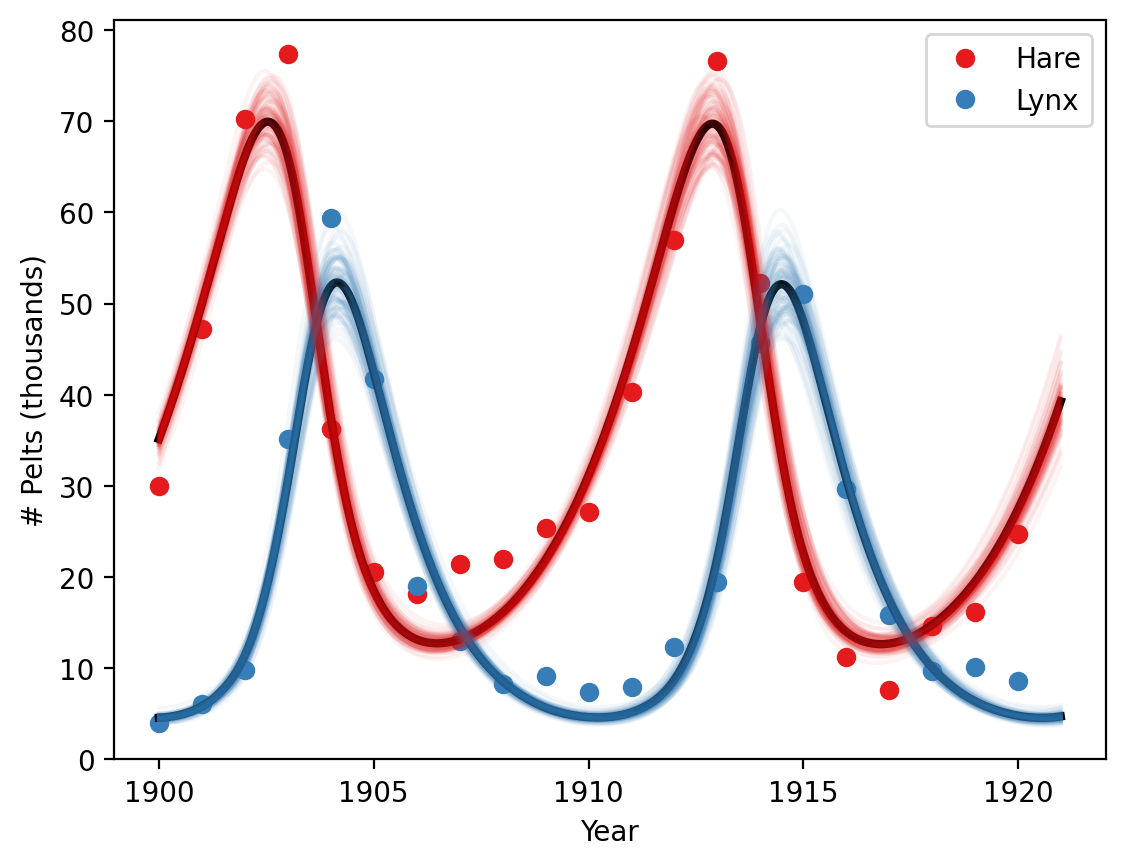

In [41]:
# data
plt.plot(data['year'], data['hare'], 'o', color=red)
plt.plot(data['year'], data['lynx'], 'o', color=blue)

# MAP prediction
θ_map = isummary['mean'].values
x, y = predator_prey_model(θ_map, t)
plt.plot(t, x, color='k', lw=3)
plt.plot(t, y, color='k', lw=3)

# posterior predictions 
posterior_samples = az.extract(idata, num_samples=100).to_dataframe()
for idx, row in posterior_samples.iterrows():
    θi = row[['b', 'h', 'ϵ', 'd', 'x0', 'y0']].values
    x, y = predator_prey_model(θi, t)
    plt.plot(t, x, color=red, alpha=0.05)
    plt.plot(t, y, color=blue, alpha=0.05)

plot_setup()

This seems pretty good, although some of the highest points in the data (both for hare and lynx) seem to be quite extreme compared to the posterior predictions.

Next let's look at the joint posterior distribution using a pair plot.

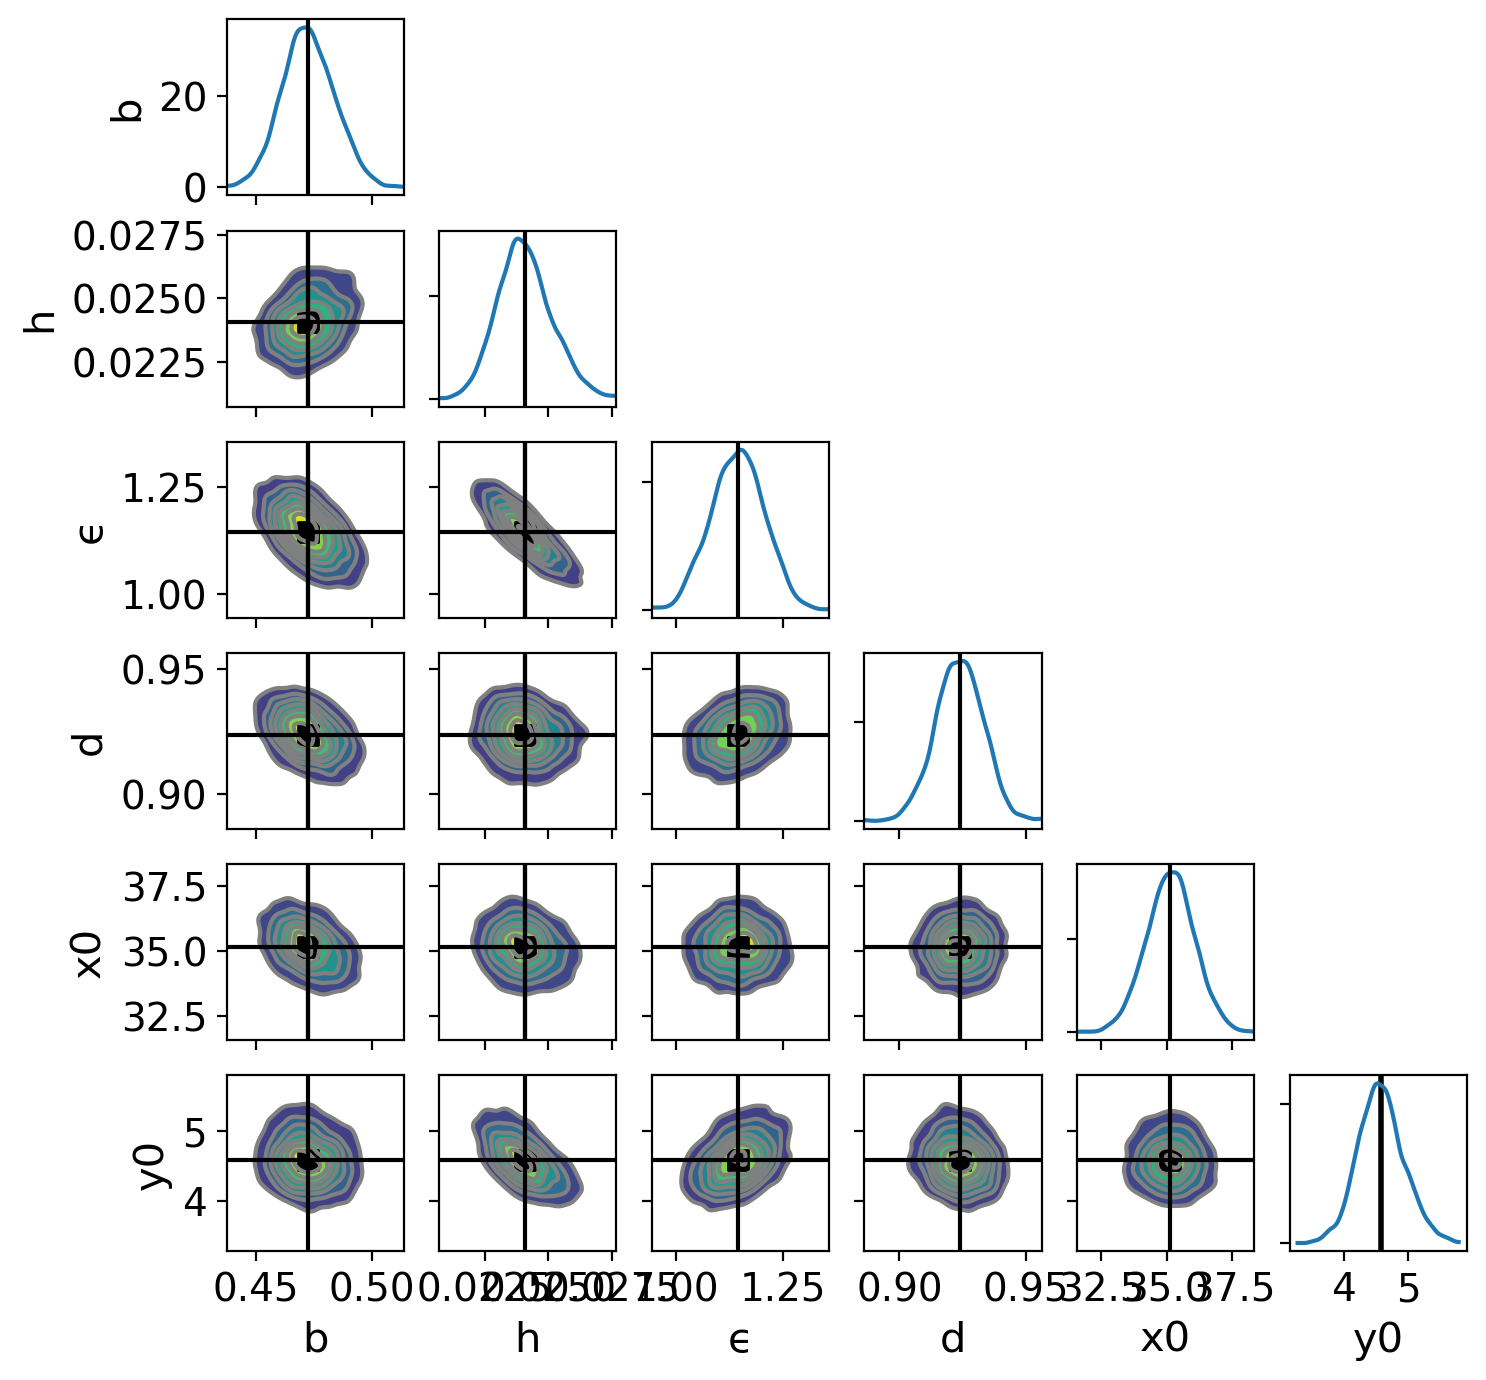

In [44]:
az.plot_pair(idata, kind='kde', figsize=(8,8),
             marginals=True, point_estimate='mean');

Here we see that the only parameters that seem strongly correlated are $h$ and $\epsilon$, which makes sense, as they appear as a product in the model. Perhaps we should redefine the model with a new parameter $\xi = \epsilon h$. Otherwise the distributions look nice and round.

# MLE using JAX

[JAX](https://jax.readthedocs.io) is a high-performance array computing library. 
it combines:
- [Autograd](https://github.com/hips/autograd) for automatic differentiation: automatic computation of gradient functions.
- [XLA](https://www.tensorflow.org/xla) (Accelerated Linear Algebra), a domain-specific compiler for linear algebra that can accelerate machine learning code.
It provides a NumPy-like interface so it's easy to learn. 
The major difference is in random number generation, but that's not a concern here.

Amazingly, JAX has an ODE solver that can be differentiated, that is, given an ODE $$\frac{dy}{dt}=F(y,t,\theta)$$ the solver computes $$\left(y, \frac{dy}{d\theta}\right)= \text{ODESolver}(F, y_0, \theta)$$

In [9]:
import numpy.random as npr
import jax.numpy as jnp
from jax import jit, grad
from jax.experimental.ode import odeint

In [13]:
@jit
def ode(xy, t, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return jnp.array([dx, dy])

@jit
def predator_prey_model(θ, t):
    θ = jnp.maximum(θ, 0) # parameters cannot be negative
    xy = odeint(ode, θ[-2:], t, *θ[:-2]).T # *** this is the amazing solver! 
    return xy

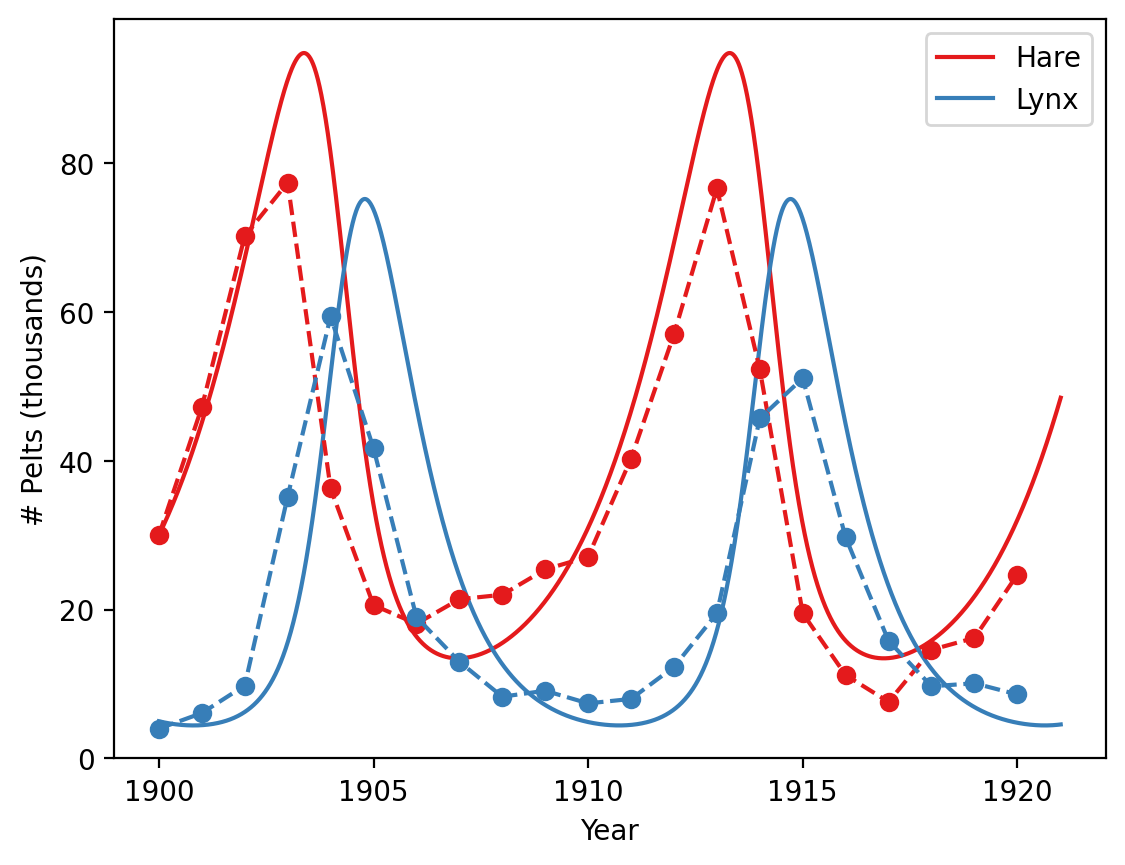

In [14]:
t = jnp.array(t)
xy = jnp.array([hare, lynx])

θ_guess = jnp.array([0.5, 0.02, 1.2, 1, 30, 5])
trange = jnp.arange(1900, 1921, 0.01)
xhat, yhat = predator_prey_model(θ_guess, trange)
plt.plot(trange, xhat, color=red)
plt.plot(trange, yhat, color=blue)
plot_setup()

In [15]:
@jit
def loss(θ, t, xy):
    xyhat = predator_prey_model(θ, t)
    return jnp.mean((xyhat - xy)**2)

In [16]:
print("Loss at i=0:", loss(θ_guess, t, xy))

Loss at i=0: 173.64784


We now use the ADAM optimizer, implemented in [Optax](https://github.com/deepmind/optax/blob/master/examples/quick_start.ipynb), a JAX optimizers library.
ADAM is a very efficient and generic gradient descent optimizer, used commonly in many deep learning:
> <div class="csl-entry">Kingma, D. P., &#38; Ba, J. L. (2015). Adam: A method for stochastic optimization. <i>3rd International Conference on Learning Representations, ICLR 2015 - Conference Track Proceedings</i>, 1–15.</div>

In [10]:
import optax

In [11]:
optimizer = optax.adam(0.01)
opt_state = optimizer.init(θ_guess)
grad_loss = grad(loss)
grad_loss(θ_guess, t, xy)

Array([-1.0745172e+03, -9.2803750e+04, -1.1163059e+03,  4.3718753e+02,
       -2.8196127e+01, -4.4924294e+01], dtype=float32)

In [12]:
%%time
θ_hat = θ_guess.copy()
for i in range(1500):
    grads = grad_loss(θ_hat, t, xy)
    Δθ, opt_state = optimizer.update(grads, opt_state, θ_hat)
    θ_hat = optax.apply_updates(θ_hat, Δθ)
    if i % 100 == 0:
        print("Loss at i={}: {}".format(i, loss(θ_hat, t, xy)))

Loss at i=0: 214.46092224121094
Loss at i=100: 20.872957229614258
Loss at i=200: 18.44591522216797
Loss at i=300: 17.033042907714844
Loss at i=400: 16.402908325195312
Loss at i=500: 16.04290771484375
Loss at i=600: 15.754288673400879
Loss at i=700: 15.491806983947754
Loss at i=800: 15.253572463989258
Loss at i=900: 15.052961349487305
Loss at i=1000: 14.870721817016602
Loss at i=1100: 14.725019454956055
Loss at i=1200: 14.591876983642578
Loss at i=1300: 14.490558624267578
Loss at i=1400: 14.410985946655273
CPU times: user 7.07 s, sys: 45.9 ms, total: 7.12 s
Wall time: 7.14 s


In [17]:
for param, pymc_val, jax_val in zip(isummary.index, isummary['mean'], θ_hat.tolist()):
    print("{}\t{:.4f}\t{:.4f}".format(param, pymc_val, jax_val))

b	0.4724	0.5018
h	0.0241	0.0256
ϵ	1.1437	1.0442
d	0.9238	0.8913
x0	35.1449	33.8595
y0	4.5769	4.0517


You can see that our JAX-based approach works very well and finds a point estimate that is similar to that of the Bayesian approach.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.